# Pipeline using Time Series Padding and Truncation

From here: https://dmbee.github.io/seglearn/auto_examples/plot_padtrunc.html

## Overview

This is a basic example using the pipeline to learn a feature representation of the time series data using **padding and truncation** *instead of sliding window segmentation*.

<img src="https://dmbee.github.io/seglearn/_images/sphx_glr_plot_padtrunc_001.png" width=300/>

---

### Play around with `PadTrunc`

In [1]:
import numpy as np
from seglearn.transform import FeatureRep, PadTrunc

In [2]:
# n_samples = 2, timesteps=[4, 5, 7], features=3
X_ = [
    np.array(
        [
            [0, .1, 10],
            [2, .1, 20],
            [3, -.1, 15],
            [4, .2, 30],
        ]
    ),
    np.array(
        [
            [-1, .1, 22],
            [-3, .2, 33],
            [-5, .3, 22],
            [-7, .4, 44],
            [-9, .5, 33],
        ]
    ),
    np.array(
        [
            [66, .1, 10],
            [66, -.1, 25],
            [66, .2, 30],
            [66, -.2, 45],
            [66, .3, 55],
            [66, -.3, 65],
            [66, .4, 70],
        ]
    )
]

# Time series target:
y_ = [
    np.array([True, False, False, True]),
    np.array([True, False, False, True, True]),
    np.array([False, False, False, True, True, False, True]),
]

In [3]:
X_

[array([[ 0. ,  0.1, 10. ],
        [ 2. ,  0.1, 20. ],
        [ 3. , -0.1, 15. ],
        [ 4. ,  0.2, 30. ]]),
 array([[-1. ,  0.1, 22. ],
        [-3. ,  0.2, 33. ],
        [-5. ,  0.3, 22. ],
        [-7. ,  0.4, 44. ],
        [-9. ,  0.5, 33. ]]),
 array([[66. ,  0.1, 10. ],
        [66. , -0.1, 25. ],
        [66. ,  0.2, 30. ],
        [66. , -0.2, 45. ],
        [66. ,  0.3, 55. ],
        [66. , -0.3, 65. ],
        [66. ,  0.4, 70. ]])]

In [4]:
y_

[array([ True, False, False,  True]),
 array([ True, False, False,  True,  True]),
 array([False, False, False,  True,  True, False,  True])]

In [5]:
pt = PadTrunc(width=5)
pt

PadTrunc(width=5)

In [6]:
X_pt, y_pt, _ = pt.fit_transform(X_, y_)

In [7]:
X_pt

array([[[ 0. ,  0.1, 10. ],
        [ 2. ,  0.1, 20. ],
        [ 3. , -0.1, 15. ],
        [ 4. ,  0.2, 30. ],
        [ 0. ,  0. ,  0. ]],

       [[-1. ,  0.1, 22. ],
        [-3. ,  0.2, 33. ],
        [-5. ,  0.3, 22. ],
        [-7. ,  0.4, 44. ],
        [-9. ,  0.5, 33. ]],

       [[66. ,  0.1, 10. ],
        [66. , -0.1, 25. ],
        [66. ,  0.2, 30. ],
        [66. , -0.2, 45. ],
        [66. ,  0.3, 55. ]]])

In [8]:
y_pt

array([[1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.]])

**⚠️ Note (from docs):**
1. Transformer for using padding and truncation to enforce fixed length on all time series in the dataset. Series longer than width are truncated to length width. **Series shorter than length width are padded at the end with `zeros` up to length width**.
2. The same behavior is applied to the target if it is a series and passed to the transformer.

In [9]:
# Try FeatureRep on top of this.
from seglearn.feature_functions import minimum, std
fr = FeatureRep(features={'min': minimum, 'std': std})
X_pt_fr = fr.fit_transform(X_pt, y_pt)

In [10]:
import pandas as pd
df = pd.DataFrame(data=X_pt_fr, columns=fr.f_labels)
display(df)

,min_0,min_1,min_2,std_0,std_1,std_2
0,0.0,-0.1,0.0,1.600000,0.101980,10.000000
1,-9.0,0.1,22.0,2.828427,0.141421,8.231646
2,66.0,-0.2,10.0,0.000000,0.185472,15.684387


✍🏻 So while in previous examples, the FeatureRep 0th dimension were *segments*, in this case, it is *samples*.

---

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [13]:
from seglearn.datasets import load_watch
from seglearn.pipe import Pype
from seglearn.transform import FeatureRep, PadTrunc

In [14]:
# load the data
data = load_watch()
X = data['X']
y = data['y']

In [15]:
# create a feature representation pipeline with PadTrunc segmentation
# the time series are between 20-40 seconds
# this truncates them all to the first 5 seconds (sampling rate is 50 Hz)

pipe = Pype(
    [
        ('trunc', PadTrunc(width=250)),  # Note.
        ('features', FeatureRep()),      # After fixing the TS "sizing" with PadTrunc, we apply FeatureRep directly on the TS.
        ('scaler', StandardScaler()),
        ('svc', LinearSVC())
    ]
)

/mnt/space/miniconda3/envs/py38_playaround-sk/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [16]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42)

In [17]:
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)  # Note!

In [18]:
print("N series in train: ", len(X_train))
print("N series in test: ", len(X_test))
print("N segments in train: ", pipe.N_train)
print("N segments in test: ", pipe.N_test)
print("Accuracy score: ", score)

N series in train:  105
N series in test:  35
N segments in train:  105
N segments in test:  35
Accuracy score:  0.8285714285714286


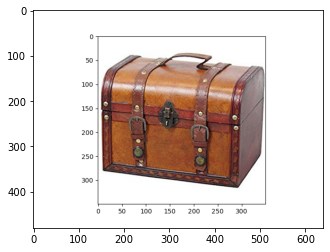

In [20]:
img = mpimg.imread('https://dmbee.github.io/seglearn/_images/sphx_glr_plot_padtrunc_001.png')
plt.imshow(img)